# Validation

There are many ways to validate a model with scalecast and this notebook introduces them and overviews the differences between dynamic and non-dynamic tuning/testing, cross-validation, backtesting, and the eye test.

- Download data: https://www.kaggle.com/robervalt/sunspots  
- See here for EDA on this dataset: https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html  
- See here for documentation on cross validation: https://scalecast.readthedocs.io/en/latest/Forecaster/Forecaster.html#src.scalecast.Forecaster.Forecaster.cross_validate

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scalecast.Forecaster import Forecaster
import diagram_creator

In [2]:
def prepare_fcst(f, test_length=0.1, fcst_length=120):
    """ adds all variables and sets the test length/forecast length in the object
    
    Args:
        f (Forecaster): the Forecaster object.
        test_length (int or float): the test length as a size or proportion.
        fcst_length (int): the forecast horizon.
        
    Returns:
        (Forecaster) the processed object.
    """
    f.generate_future_dates(fcst_length)
    f.set_test_length(test_length)
    f.set_validation_length(f.test_length)
    f.eval_cis()
    f.add_seasonal_regressors("month")
    for i in np.arange(60, 289, 12):  # 12-month cycles from 12 to 288 months
        f.add_cycle(i)
    f.add_ar_terms(120)  # AR 1-120
    f.add_AR_terms((20, 12))  # seasonal AR up to 20 years, spaced one year apart
    f.add_seasonal_regressors("year")
    #f.auto_Xvar_select(irr_cycles=[120],estimator='gbt')
    return f


def export_results(f):
    """ returns a dataframe with all model results given a Forecaster object.
    
    Args:
        f (Forecaster): the Forecaster object.
        
    Returns:
        (DataFrame) the dataframe with the pertinent results.
    """
    results = f.export("model_summaries", determine_best_by="TestSetMAE")
    return results[
        [
            "ModelNickname",
            "TestSetRMSE",
            "InSampleRMSE",
            "ValidationMetric",
            "ValidationMetricValue",
            "HyperParams",
            "TestSetLength",
            "DynamicallyTested",
        ]
    ]

## Load Forecaster Object
- we choose 120 periods (10 years) for all validation and forecasting
- 10 years of observervations to tune model hyperparameters, 10 years to test, and a forecast horizon of 10 years

In [3]:
df = pd.read_csv("Sunspots.csv", index_col=0, names=["Date", "Target"], header=0)
f = Forecaster(y=df["Target"], current_dates=df["Date"])
prepare_fcst(f)

Forecaster(
    DateStartActuals=1749-01-31T00:00:00.000000000
    DateEndActuals=2021-01-31T00:00:00.000000000
    Freq=M
    N_actuals=3265
    ForecastLength=120
    Xvars=['month', 'cycle60sin', 'cycle60cos', 'cycle72sin', 'cycle72cos', 'cycle84sin', 'cycle84cos', 'cycle96sin', 'cycle96cos', 'cycle108sin', 'cycle108cos', 'cycle120sin', 'cycle120cos', 'cycle132sin', 'cycle132cos', 'cycle144sin', 'cycle144cos', 'cycle156sin', 'cycle156cos', 'cycle168sin', 'cycle168cos', 'cycle180sin', 'cycle180cos', 'cycle192sin', 'cycle192cos', 'cycle204sin', 'cycle204cos', 'cycle216sin', 'cycle216cos', 'cycle228sin', 'cycle228cos', 'cycle240sin', 'cycle240cos', 'cycle252sin', 'cycle252cos', 'cycle264sin', 'cycle264cos', 'cycle276sin', 'cycle276cos', 'cycle288sin', 'cycle288cos', 'AR1', 'AR2', 'AR3', 'AR4', 'AR5', 'AR6', 'AR7', 'AR8', 'AR9', 'AR10', 'AR11', 'AR12', 'AR13', 'AR14', 'AR15', 'AR16', 'AR17', 'AR18', 'AR19', 'AR20', 'AR21', 'AR22', 'AR23', 'AR24', 'AR25', 'AR26', 'AR27', 'AR28', 'AR29', 

In [4]:
f.set_estimator('gbt')

In the [feature_selection](https://scalecast-examples.readthedocs.io/en/latest/misc/feature-selection/feature_selection.html) notebook, gbt was chosen as the best model class out of several tried. We will show all examples with this estimator.

## Default Model Parameters
- one with dynamic testing
- one with non-dynamic testing
- the difference can be expressed by taking the case of a simple autoregressive model, such that:


### Non-Dynamic Autoregressive Predictions

$$
x_t = \alpha * x_{t-1} + e_t
$$

Over an indefinite forecast horizon, the above equation would only work if you knew the value for $x_{t-1}$. Going more than one period into the future, you would stop knowing what that value is. In a test-set of data, of course, you do know all values into the forecast horizon, but to be more realistic, you could write an equation for a two-step forecast like this:

### Dynamic Autoregressive Predictions

$$
\hat{x_t} = \hat{\alpha} * x_{t-1}
$$
$$
x_{t+1} = \hat{\alpha} * \hat{x}_t + e_{t+1}
$$

Using these two equations, which scalecast refers to as dynamic forecasting, you could evaluate any forecast horizon by plugging in predicted values for $x_{t-1}$ or ${x_t}$ over periods in which you did not know it. This is default behavior for all models tested through scalecast, but it is not default for tuning models. We will explore dynamic tuning soon. First, let's see in practical terms the difference between non-dynamic and dynamic testing.

In [5]:
f.manual_forecast(call_me="gbt_default_non-dynamic", dynamic_testing=False)
f.manual_forecast(call_me="gbt_default_dynamic")  # default is dynamic testing

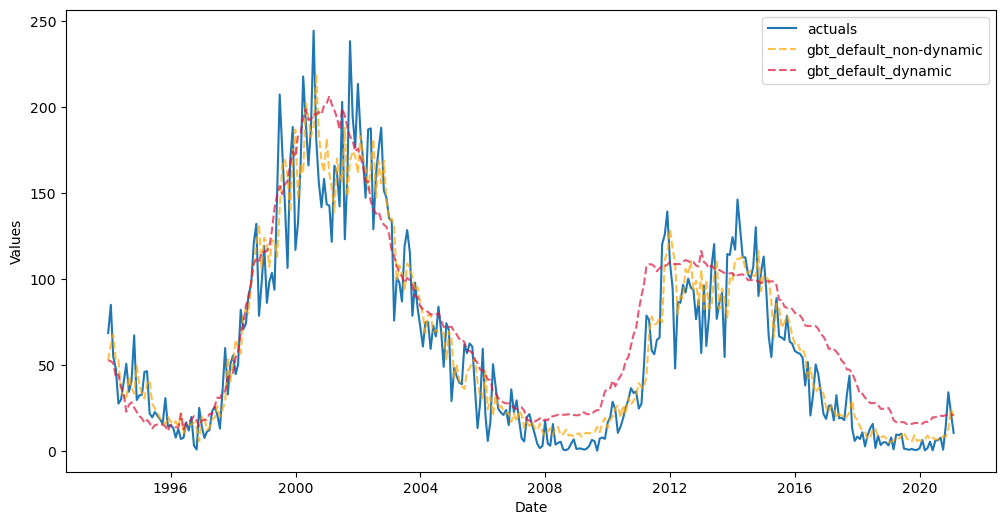

In [6]:
f.plot_test_set(
    models=[
        "gbt_default_non-dynamic", 
        "gbt_default_dynamic"
    ], 
    include_train=False,
)
plt.show()

It appears that the non-dynamically tested model performed significantly better than the other, but looks can be deceiving. In essence, the non-dynamic model was only tested for its ability to perform 326 one-step forecasts and its final metric is an average of these one-step forecasts. It could be a good idea to set `dynamic_testing=False` if you want to speed up the testing process or if you only care about how your model would perform one step into the future. But to report the test-set metric from this model as if it could be expected to do that well for the full 326 periods into the future is misleading. The other model that was dynamically tested can be more realistically trusted in that regard.

In [7]:
export_results(f)

,ModelNickname,TestSetRMSE,InSampleRMSE,ValidationMetric,ValidationMetricValue,HyperParams,TestSetLength,DynamicallyTested
0,gbt_default_non-dynamic,18.723179,18.841544,NaN,NaN,{},326,False
1,gbt_default_dynamic,24.456923,18.841544,NaN,NaN,{},326,True


## Tune the model to find optimal hyperparameters
- Create a validation grid
- Try three strategies to tune the parameters:
  - Train/validation/test split
    - Hyperparameters are tried on the validation set
  - Train/test split with 5-fold time-series cross-validation on training set
    - Training data split 5 times into train/validations set
    - Models trained on training set only
    - Validated out-of-sample
    - All data available before each validation split sequentially used to train the model
  - Train/test split with 5-fold time-series rolling cross-validation on training set
    - Rolling is different in that each train/validation split is the same size

In [8]:
grid = {
    "max_depth": [2, 3, 5],
    "max_features": ["sqrt", "auto"],
    "subsample": [0.8, 0.9, 1],
}

In [9]:
f.ingest_grid(grid)

### Train/Validation/Test Split
- The data's sequence is always maintained in time-series splits with scalecast

![](./mermaid-diagram-20220614194220.png)

In [10]:
f.tune(dynamic_tuning=True)
f.auto_forecast(
    call_me="gbt_tuned"
)  # automatically uses optimal paramaeters suggested from the tuning process

In [11]:
f.export_validation_grid("gbt_tuned").sort_values('AverageMetric').head(10)

,max_depth,max_features,subsample,Fold0Metric,AverageMetric,MetricEvaluated
7,3,sqrt,0.9,43.623057,43.623057,rmse
12,5,sqrt,0.8,43.667072,43.667072,rmse
6,3,sqrt,0.8,44.015361,44.015361,rmse
8,3,sqrt,1,44.807485,44.807485,rmse
0,2,sqrt,0.8,46.093143,46.093143,rmse
2,2,sqrt,1,53.206496,53.206496,rmse
14,5,sqrt,1,60.587243,60.587243,rmse
10,3,auto,0.9,65.424393,65.424393,rmse
15,5,auto,0.8,66.530315,66.530315,rmse
13,5,sqrt,0.9,67.459775,67.459775,rmse


### 5-Fold Time Series Cross Validation
- Split training set into k (5) folds
- Each validation set is the same size and determined such that: `val_size = n_obs // (folds + 1)`
  - The last training set will be the same size or almost the same size as the validation sets
- Model trained and re-trained with all data that came before each validation slice
- Each fold tested out of sample on its validation set
- Final error is an average of the out-of-sample error obtained from each fold
- The chosen hyperparameters are determined by which final error was minimized
- Below is an example with a dataset sized 100 observations and in which 10 observations are held out for testing and the remaining 90 observations are used as the training set:

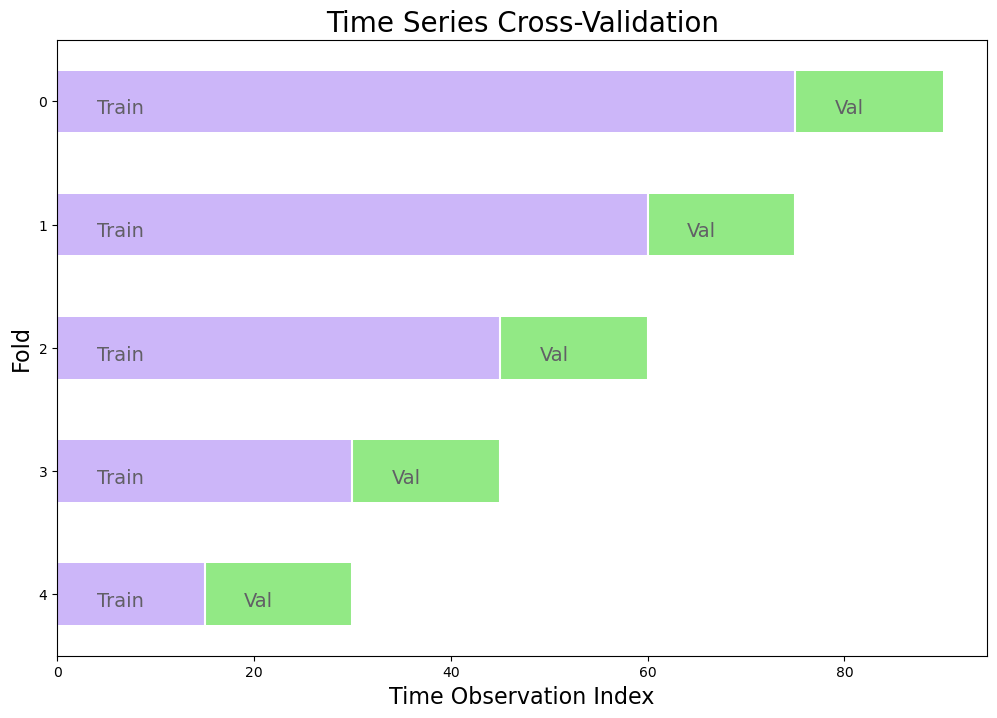

In [12]:
diagram_creator.create_cv()

The final error, *E*, can be expressed as an average of the error from each fold *i*: 
$$
E = \frac{1}{n}\sum_{i=0}^{n-1}{(e_i)}
$$

In [13]:
f.cross_validate(
    k=5, 
    dynamic_tuning=True,
    test_length = None, # default so that last test and train sets are same size (or close to the same)
    train_length = None, # default uses all observations before each test set
    space_between_sets = None, # default adds a length equal to the test set between consecutive sets
    verbose = True, # print out info about each fold
)
f.auto_forecast(call_me="gbt_cv")

Num hyperparams to try for the gbt model: 18.
Fold 0: Train size: 2450 (1749-01-31 00:00:00 - 1953-02-28 00:00:00). Test Size: 489 (1953-03-31 00:00:00 - 1993-11-30 00:00:00). 
Fold 1: Train size: 1961 (1749-01-31 00:00:00 - 1912-05-31 00:00:00). Test Size: 489 (1912-06-30 00:00:00 - 1953-02-28 00:00:00). 
Fold 2: Train size: 1472 (1749-01-31 00:00:00 - 1871-08-31 00:00:00). Test Size: 489 (1871-09-30 00:00:00 - 1912-05-31 00:00:00). 
Fold 3: Train size: 983 (1749-01-31 00:00:00 - 1830-11-30 00:00:00). Test Size: 489 (1830-12-31 00:00:00 - 1871-08-31 00:00:00). 
Fold 4: Train size: 494 (1749-01-31 00:00:00 - 1790-02-28 00:00:00). Test Size: 489 (1790-03-31 00:00:00 - 1830-11-30 00:00:00). 
Chosen paramaters: {'max_depth': 5, 'max_features': 'sqrt', 'subsample': 1}.


In [14]:
f.export_validation_grid("gbt_cv").sort_values("AverageMetric").head(10)

,max_depth,max_features,subsample,Fold0Metric,Fold1Metric,Fold2Metric,Fold3Metric,Fold4Metric,AverageMetric,MetricEvaluated
14,5,sqrt,1,75.881634,85.585377,79.162305,83.264294,96.912215,84.161165,rmse
12,5,sqrt,0.8,90.328729,96.703967,48.606034,80.703070,111.586242,85.585609,rmse
13,5,sqrt,0.9,108.327532,95.594713,61.082475,61.798101,108.437289,87.048022,rmse
16,5,auto,0.9,89.047882,92.811981,74.332318,86.321627,112.510827,91.004927,rmse
0,2,sqrt,0.8,105.541098,78.227464,103.386493,77.997451,115.573720,96.145245,rmse
8,3,sqrt,1,64.668019,119.509341,93.877028,93.740770,114.533147,97.265661,rmse
7,3,sqrt,0.9,75.061438,85.898970,122.575339,91.157722,119.005642,98.739822,rmse
2,2,sqrt,1,59.907395,88.529044,113.535870,118.721240,117.856393,99.709989,rmse
17,5,auto,1,111.676983,96.506098,70.688360,102.882864,118.365703,100.024002,rmse
6,3,sqrt,0.8,93.640946,85.464725,100.451257,109.813079,111.415691,100.157140,rmse


### 5-Fold Rolling Time Series Cross Validation
- Split training set into k (5) folds
- Each validation set is the same size
- Each training set is also the same size as each validation set
- Each fold tested out of sample
- Final error is an average of the out-of-sample error obtained from each folds
- The chosen hyperparameters are determined by which final error was minimized
- Below is an example with a dataset sized 100 observation and in which 10 observations are held out for testing and the remaining 90 observations are used as the training set:

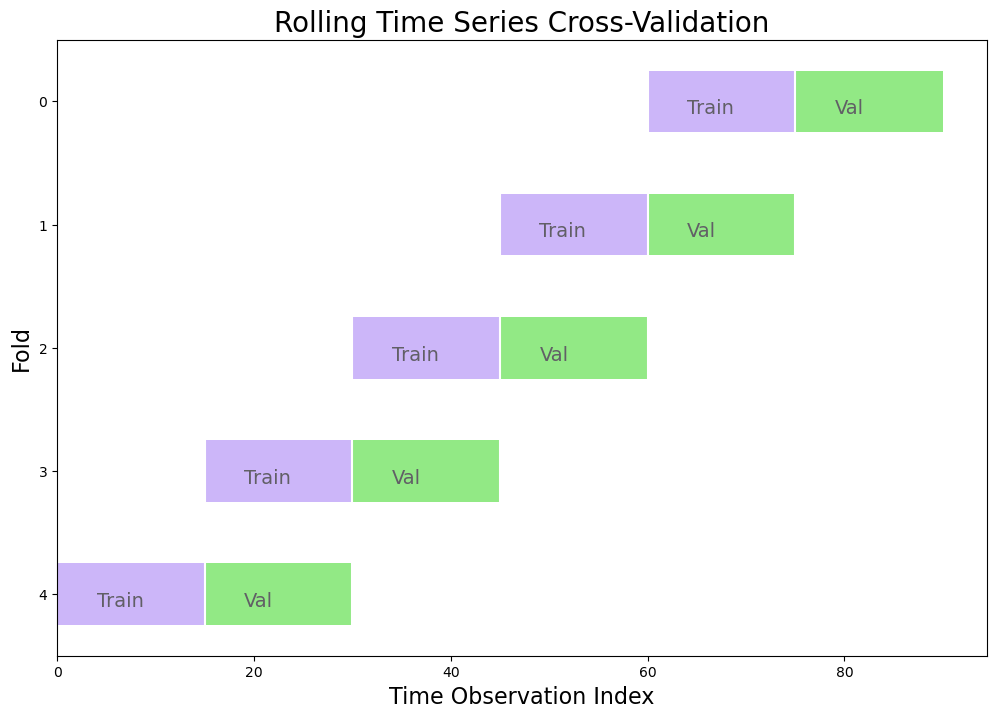

In [15]:
diagram_creator.create_rolling_cv()

In [16]:
f.cross_validate(
    k=5, 
    rolling=True, 
    dynamic_tuning=True,
    test_length = None, # with rolling = True, makes all train and test sets the same size
    train_length = None, # with rolling = True, makes all train and test sets the same size
    space_between_sets = None, # default adds a length equal to the test set between consecutive sets
    verbose = True, # print out info about each fold
)
f.auto_forecast(call_me="gbt_rolling_cv")

Num hyperparams to try for the gbt model: 18.
Fold 0: Train size: 489 (1912-06-30 00:00:00 - 1953-02-28 00:00:00). Test Size: 489 (1953-03-31 00:00:00 - 1993-11-30 00:00:00). 
Fold 1: Train size: 489 (1871-09-30 00:00:00 - 1912-05-31 00:00:00). Test Size: 489 (1912-06-30 00:00:00 - 1953-02-28 00:00:00). 
Fold 2: Train size: 489 (1830-12-31 00:00:00 - 1871-08-31 00:00:00). Test Size: 489 (1871-09-30 00:00:00 - 1912-05-31 00:00:00). 
Fold 3: Train size: 489 (1790-03-31 00:00:00 - 1830-11-30 00:00:00). Test Size: 489 (1830-12-31 00:00:00 - 1871-08-31 00:00:00). 
Fold 4: Train size: 489 (1749-06-30 00:00:00 - 1790-02-28 00:00:00). Test Size: 489 (1790-03-31 00:00:00 - 1830-11-30 00:00:00). 
Chosen paramaters: {'max_depth': 5, 'max_features': 'sqrt', 'subsample': 0.9}.


In [17]:
f.export_validation_grid("gbt_rolling_cv").sort_values("AverageMetric").head(10)

,max_depth,max_features,subsample,Fold0Metric,Fold1Metric,Fold2Metric,Fold3Metric,Fold4Metric,AverageMetric,MetricEvaluated
13,5,sqrt,0.9,52.067612,75.101589,47.665446,73.458303,110.673685,71.793327,rmse
11,3,auto,1,61.780860,70.554830,48.914548,74.467054,110.351684,73.213795,rmse
9,3,auto,0.8,59.526670,76.807231,48.096324,74.276742,110.628222,73.867038,rmse
17,5,auto,1,68.884924,63.475008,52.178487,73.895434,111.100209,73.906812,rmse
7,3,sqrt,0.9,44.798329,69.131312,54.226665,93.287371,115.134538,75.315643,rmse
8,3,sqrt,1,56.409051,84.081666,49.339527,75.453036,111.791536,75.414963,rmse
3,2,auto,0.8,61.498220,73.383101,48.898466,78.773421,115.272207,75.565083,rmse
12,5,sqrt,0.8,63.732031,78.140692,47.053796,73.473322,115.558499,75.591668,rmse
5,2,auto,1,69.075181,67.852121,53.383812,75.150129,115.413148,76.174878,rmse
14,5,sqrt,1,48.860162,84.807936,49.921226,89.144401,110.995682,76.745881,rmse


### View results

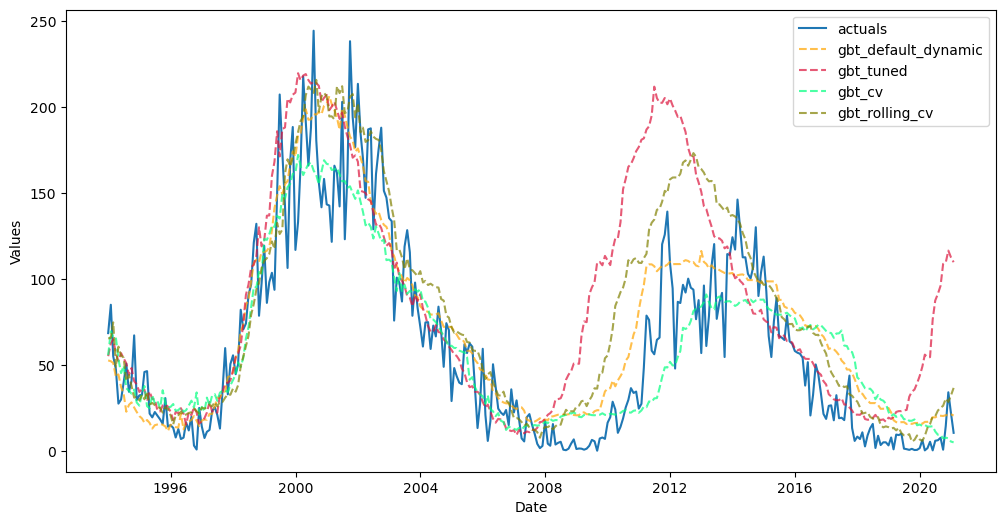

In [18]:
f.plot_test_set(
    models=[
        "gbt_default_dynamic",
        "gbt_tuned", 
        "gbt_cv", 
        "gbt_rolling_cv",
    ], 
    include_train=False,
)
plt.show()

In [19]:
pd.set_option('max_colwidth', 60)
export_results(f)

,ModelNickname,TestSetRMSE,InSampleRMSE,ValidationMetric,ValidationMetricValue,HyperParams,TestSetLength,DynamicallyTested
0,gbt_default_non-dynamic,18.723179,18.841544,NaN,NaN,{},326,False
1,gbt_default_dynamic,24.456923,18.841544,NaN,NaN,{},326,True
2,gbt_cv,25.604943,13.063379,rmse,84.161165,"{'max_depth': 5, 'max_features': 'sqrt', 'subsample': 1}",326,True
3,gbt_rolling_cv,34.248137,12.789779,rmse,71.793327,"{'max_depth': 5, 'max_features': 'sqrt', 'subsample': 0.9}",326,True
4,gbt_tuned,50.777958,20.342340,rmse,43.623057,"{'max_depth': 3, 'max_features': 'sqrt', 'subsample': 0.9}",326,True


## Backtest models
- Backtesting is a process in which the final chosen model is re-validated by seeing its average performance on the last x-number of forecast horizons available in the data
- With scalecast, pipeline objects can be built and backtest all applied models to see the best one over several forecast horizons
- See the [documentation](https://scalecast.readthedocs.io/en/latest/Forecaster/Pipeline.html#src.scalecast.Pipeline.Pipeline.backtest) for more information

In [20]:
from scalecast.Pipeline import Pipeline
from scalecast.util import backtest_metrics

In [21]:
def forecaster(f):
    f.set_estimator('gbt')
    f.set_validation_length(int(len(f.y)*.1)) # 10% val length each time
    f.add_seasonal_regressors("month")
    for i in np.arange(60, 289, 12):  # 12-month cycles from 12 to 288 months
        f.add_cycle(i)
    f.add_ar_terms(120)  # AR 1-120
    f.add_AR_terms((20, 12))  # seasonal AR up to 20 years, spaced one year apart
    f.add_seasonal_regressors("year")
    
    f.manual_forecast(call_me='gbt_default_dynamic')
    
    f.ingest_grid(grid)
    
    f.tune(dynamic_tuning = True)
    f.auto_forecast(call_me='gbt_tuned')
    
    f.cross_validate(dynamic_tuning = True)
    f.auto_forecast(call_me='gbt_cv')
    
    f.cross_validate(dynamic_tuning = True, rolling = True)
    f.auto_forecast(call_me='gbt_rolling_cv')

In [22]:
pipeline = Pipeline(steps = [('Forecast',forecaster)])

In [23]:
backtest_results = pipeline.backtest(
    f,
    test_length = 0,
    fcst_length = 120,
    jump_back = 120, # place 120 obs between each training set
    cis = False,
    verbose = True,
)

In [24]:
bm = backtest_metrics(backtest_results,mets=['rmse','mae','r2'])
bm

Iter0      Iter1      Iter2      Iter3  \
Model               Metric                                               
gbt_default_dynamic rmse    29.787489  32.631984  40.218024  57.655588   
                    mae     24.725663  25.120353   32.70369  45.658795   
                    r2       0.499971   0.718315   0.652106   0.466619   
gbt_tuned           rmse    21.793363  38.201181  34.145031  55.637363   
                    mae     17.232072  29.314773  26.055781   42.62898   
                    r2       0.732345   0.613962   0.749239   0.503307   
gbt_cv              rmse    27.290614  30.871908  38.859572  55.141773   
                    mae     21.956079  24.026144  30.078019  42.157045   
                    r2       0.580286   0.747883   0.675211   0.512116   
gbt_rolling_cv      rmse    26.080319    31.8572  34.485633  43.732603   
                    mae     21.003643  24.701014  27.536833  37.057153   
                    r2       0.616687   0.731533   0.744211   0.693122   

                                Iter4    Average  
Model               Metric                        
gbt_default_dynamic rmse    88.550393  49.768696  
                    mae     56.387906  36.919281  
                    r2      -0.415585   0.384285  
gbt_tuned           rmse    99.862839  49.927956  
                    mae     63.122565  35.670834  
                    r2      -0.800374   0.359696  
gbt_cv              rmse    35.648112  37.562396  
                    mae      27.85357  29.214172  
                    r2       0.770582   0.657215  
gbt_rolling_cv      rmse    38.312404  34.893632  
                    mae     28.484026  27.756534  
                    r2       0.735007   0.704112

In [25]:
bmr = bm.reset_index()

In [26]:
bmrrmse = bmr.loc[bmr['Metric'] == 'rmse'].sort_values('Average')
best_model = bmrrmse.iloc[0,0]
best_model

'gbt_rolling_cv'

In [27]:
rmse = bmr.loc[
    (bmr['Model'] == best_model) & (bmr['Metric'] == 'rmse'),
    'Average',
].values[0]
mae = bmr.loc[
    (bmr['Model'] == best_model) & (bmr['Metric'] == 'mae'),
    'Average',
].values[0]
r2 = bmr.loc[
    (bmr['Model'] == best_model) & (bmr['Metric'] == 'r2'),
    'Average',
].values[0]

In [28]:
print(
    f"The best model, according to the RMSE over 5 backtest iterations was {best_model}."
    " On average, we can expect this model to have an RMSE of"
    f" {rmse:.2f}, MAE of {mae:.2f}, and R2 of {r2:.2%} over a full 120-period"
    " forecast window."
)

The best model, according to the RMSE over 5 backtest iterations was gbt_rolling_cv. On average, we can expect this model to have an RMSE of 34.89, MAE of 27.76, and R2 of 70.41% over a full 120-period forecast window.


An extension of this analysis could be to choose regressors more carefully (see [here](https://scalecast-examples.readthedocs.io/en/latest/misc/feature-selection/feature_selection.html)) and to use more complex models (see [here](https://scalecast-examples.readthedocs.io/en/latest/rnn/rnn.html)).

## The Eye Test

In addition to all the objective validation performed in this notebook, one of the most important questions to ask is if the forecast looks reasonable. Does it pass the common sense test? Below, we plot the 120-forecast period horizon from the best model.

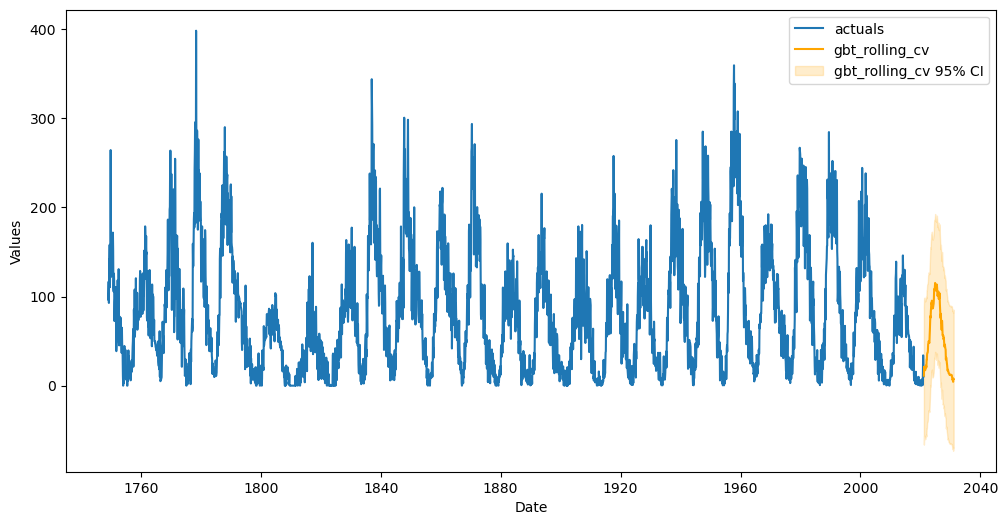

In [29]:
f.plot(models=best_model, ci = True)
plt.show()